In [1]:
%load_ext rpy2.ipython
import pandas as pd
from Bio import SeqIO

In [5]:
%%R
library(ShortRead)
library(dada2)
library(doParallel)
library(dplyr)
library(ggplot2)

### Checking what packages and version is running

In [6]:
%%R
ip = as.data.frame(installed.packages()[,c(1,3:4)])
ip = ip[is.na(ip$Priority),1:2,drop=FALSE]
print(ip, row.names=FALSE)

              Package     Version
        BiocInstaller      1.24.0
                dada2       1.2.0
         RcppParallel      4.3.19
            ShortRead      1.32.0
              acepack       1.4.1
                 ade4       1.7-4
             annotate      1.52.0
        AnnotationDbi      1.36.0
                  ape         3.5
           assertthat         0.1
            base64enc       0.1-3
                   BH    1.60.0-2
              Biobase      2.34.0
         BiocGenerics      0.20.0
        BiocInstaller      1.22.3
         BiocParallel       1.8.1
           biomformat       1.2.0
           Biostrings      2.42.0
               bitops       1.0-6
                 boot      1.3-18
                  car       2.1-3
                caret      6.0-73
              caTools      1.17.1
                chron      2.3-47
                class      7.3-14
          coenocliner       0.2-2
           colorspace       1.3-0
               crayon       1.3.2
              

### Grabbing Demultiplexed Libraries and Organizing

In [7]:
%%R 
##Sea Star Libraries
path  = "data/demult/"
fns = list.files(path)
head(fns,n=10)

 [1] "8106_PC_F_filt.fastq.gz" "8106_PC_R_filt.fastq.gz"
 [3] "8106_PC.R1.fq.gz"        "8106_PC.R2.fq.gz"       
 [5] "8110_BP_F_filt.fastq.gz" "8110_BP_R_filt.fastq.gz"
 [7] "8110_BP.R1.fq.gz"        "8110_BP.R2.fq.gz"       
 [9] "8116_BP_F_filt.fastq.gz" "8116_BP_R_filt.fastq.gz"


In [25]:
%%R
fastqs = fns[grepl(".fq.gz$", fns)]
fastqs = sort(fastqs) # Sort ensures forward/reverse reads are in same order
fnFs = fastqs[grepl("R1", fastqs)] # Just the forward read files
fnRs = fastqs[grepl("R2", fastqs)] # Just the reverse read files

# Get sample names from the first part of the forward read filenames
sample_names = sapply(strsplit(fnFs, "[.]"), `[`, 1)

# Fully specify the path for the fnFs and fnRs
fnFs = file.path(path, fnFs)
fnRs = file.path(path, fnRs)

print(fnFs[[1]]) 
print(fnRs[[1]])

[1] "data/demult//8106_PC.R1.fq.gz"
[1] "data/demult//8106_PC.R2.fq.gz"


### Grabbing Demultiplexed Libaries for blanks

In [8]:
%%R
##Blank Libraries
pathblank  = "data/demultiplex_blank/"
fnsblank = list.files(pathblank)

In [9]:
%%R
fnsblank

[1] "Plate2blank_F_filt.fastq.gz" "Plate2blank_R_filt.fastq.gz"
[3] "Plate2blank.R1.fq.gz"        "Plate2blank.R2.fq.gz"       
[5] "Plate3blank_F_filt.fastq.gz" "Plate3blank_R_filt.fastq.gz"
[7] "Plate3blank.R1.fq.gz"        "Plate3blank.R2.fq.gz"       


In [10]:
%%R
fastqsblank = fnsblank[grepl(".fq.gz$", fnsblank)]
fastqsblank = sort(fastqsblank) # Sort ensures forward/reverse reads are in same order\
fnFsblank = fastqsblank[grepl("R1", fastqsblank)] # Just the forward read files
fnRsblank = fastqsblank[grepl("R2", fastqsblank)] # Just the reverse read files
# Get sample names from the first part of the forward read filenames
sample_names_blank = sapply(strsplit(fnFsblank, "[.]"), `[`, 1)

# Fully specify the path for the fnFs and fnRs
fnFsblank <- paste0(pathblank, fnFsblank)
fnRsblank <- paste0(pathblank, fnRsblank)
                                                   
print(fnFsblank[[1]]) 
print(fnRsblank[[1]])

[1] "data/demultiplex_blank/Plate2blank.R1.fq.gz"
[1] "data/demultiplex_blank/Plate2blank.R2.fq.gz"


### Plotting Quality Score for Foward and Reverse Reads (Echinoderm Libraries)

[1] "C233_CF"


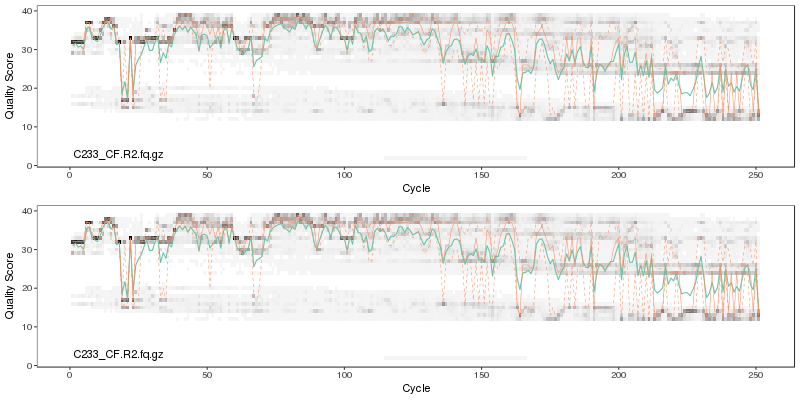

In [27]:
%%R -h 400 -w 800

sample = "C233_CF"
N = grep(sample, sample_names)

print(sample_names[[N]])

p1 = dada2::plotQualityProfile(fnRs[[N]])
p2 = dada2::plotQualityProfile(fnRs[[N]])

gridExtra::grid.arrange(p1, p2, nrow = 2)

### Making directory for filtered reads

In [29]:
%%R
filtFs = paste0(path, sample_names, "_F_filt.fastq.gz")
filtRs = paste0(path, sample_names, "_R_filt.fastq.gz")

In [11]:
%%R
filtFsblank = paste0(pathblank, sample_names_blank, "_F_filt.fastq.gz")
filtRsblank = paste0(pathblank, sample_names_blank, "_R_filt.fastq.gz")

In [12]:
%%R
filtFsblank

[1] "data/demultiplex_blank/Plate2blank_F_filt.fastq.gz"
[2] "data/demultiplex_blank/Plate3blank_F_filt.fastq.gz"


### Trim and Filter

In [33]:
%%R
registerDoParallel(cores=10)

filter_fq = function (i) {
  fastqPairedFilter(c(fnFs[i], fnRs[i]), c(filtFs[i], filtRs[i]),
                    trimLeft=c(10, 10), truncLen=c(150,150), 
                    maxN=0, maxEE=2, truncQ=2, 
                    compress=TRUE, verbose=FALSE)
  
  data.frame(before_trimming = length(readFastq(fnFs[i])),
             after_trimming = length(readFastq(filtFs[i])), 
             sampleID = sample_names[i])
}


filt_df = plyr::ldply(1:length(sample_names), filter_fq, .parallel = TRUE)

In [13]:
%%R
registerDoParallel(cores=10)

filter_fq_blank = function (i) {
  fastqPairedFilter(c(fnFsblank[i], fnRsblank[i]), c(filtFsblank[i], filtRsblank[i]),
                    trimLeft=c(10, 10), truncLen=c(150,150), 
                    maxN=0, maxEE=2, truncQ=2, 
                    compress=TRUE, verbose=FALSE)
  
  data.frame(before_trimming = length(readFastq(fnFsblank[i])),
             after_trimming = length(readFastq(filtFsblank[i])), 
             sampleID = sample_names_blank[i])
}


filt_df_blank = plyr::ldply(1:length(sample_names_blank), filter_fq_blank, .parallel = TRUE)

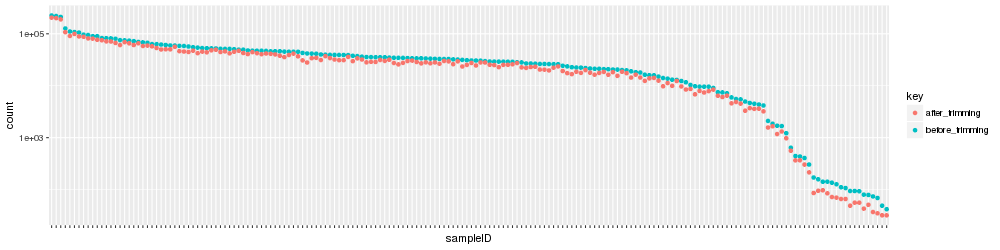

In [34]:
%%R -w 1000 -h 250
d = filt_df %>%
    tidyr::gather(key, count, -sampleID) %>% 
    {
        ord = filter(., key == "before_trimming") %>%
            arrange(desc(count)) %>%
            magrittr::extract2("sampleID")
        .$sampleID = factor(.$sampleID, levels = ord)
        .
    }

p = ggplot(d, aes(x = sampleID, y = count, color = key))

p = p + geom_point()

p = p + scale_y_log10()

p = p + theme(axis.text.x = element_blank())

p

### Deduplicating Reads 

In [35]:
%%R
derepFs = derepFastq(filtFs, verbose = FALSE)
derepRs = derepFastq(filtRs, verbose = FALSE)

names(derepFs) = sample_names
names(derepRs) = sample_names

In [14]:
%%R
derepFsblank = derepFastq(filtFsblank, verbose = FALSE)
derepRsblank = derepFastq(filtRsblank, verbose = FALSE)

names(derepFsblank) = sample_names_blank
names(derepRsblank) = sample_names_blank

In [37]:
%%R
save(derepFs, derepRs, file = "data/derep.RData")

In [15]:
%%R
save(derepFsblank, derepRsblank, file = "data/derepblank.RData")

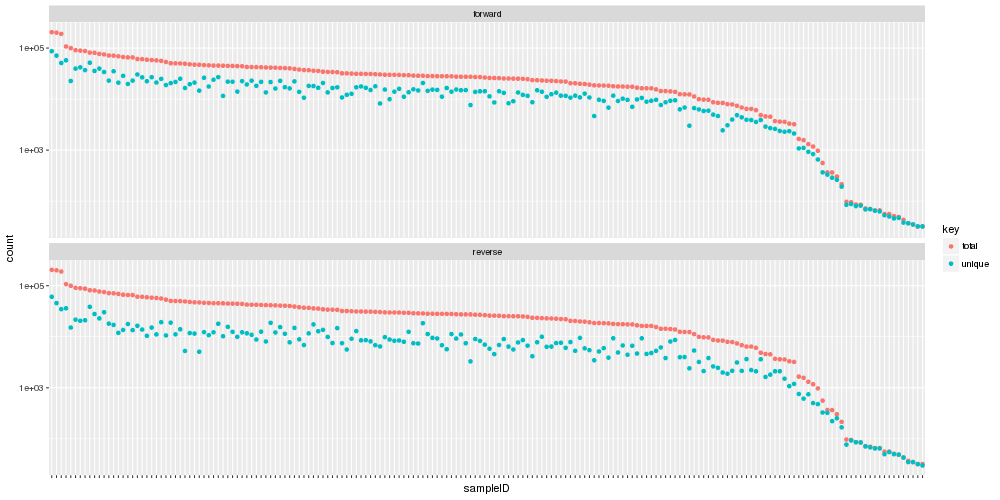

In [39]:
%%R  -w 1000 -h 500
derep_info = function(derep, read) {
    data.frame(total = sum(derep$unique), 
               unique = length(derep$unique),
               read = read)
}

d1 = plyr::ldply(derepFs, derep_info, read = "forward", .id = "sampleID")
d2 = plyr::ldply(derepRs, derep_info, read = "reverse", .id = "sampleID")
d = rbind(d1, d2) %>%
    tidyr::gather(key, count, -sampleID, -read) %>% {
        ord = filter(., key == "total", read == "forward") %>%
            arrange(desc(count)) %>%
            magrittr::extract2("sampleID")
        .$sampleID = factor(.$sampleID, levels = ord)
        .
    }

p = ggplot(d, aes(x = sampleID, y = count, color = key))

p = p + facet_wrap(~read, ncol = 1)

p = p + geom_point()

p = p + scale_y_log10()

p = p + theme(axis.text.x = element_blank())

p


### Infer sequence variants using DADA2

In [ ]:
%%R
dadaFs = plyr::llply(derepFs, dada, err=inflateErr(tperr1,3), selfConsist = TRUE, multithread=35, verbose=FALSE)
dadaRs = plyr::llply(derepRs, dada, err=inflateErr(tperr1,3), selfConsist = TRUE, multithread=35, verbose=FALSE)

In [16]:
%%R
dadaFsblank = plyr::llply(derepFsblank, dada, err=inflateErr(tperr1,3), selfConsist = TRUE, multithread=20, verbose=FALSE)
dadaRsblank = plyr::llply(derepRsblank, dada, err=inflateErr(tperr1,3), selfConsist = TRUE, multithread=20, verbose=FALSE)

Sample 1 - 1518 reads in 1158 unique sequences.
   selfConsist step 2 
   selfConsist step 3 


Convergence after  3  rounds.
Sample 1 - 488 reads in 375 unique sequences.
   selfConsist step 2 
   selfConsist step 3 


Convergence after  3  rounds.
Sample 1 - 1518 reads in 1004 unique sequences.
   selfConsist step 2 
   selfConsist step 3 
   selfConsist step 4 


Convergence after  4  rounds.
Sample 1 - 488 reads in 327 unique sequences.
   selfConsist step 2 
   selfConsist step 3 


Convergence after  3  rounds.


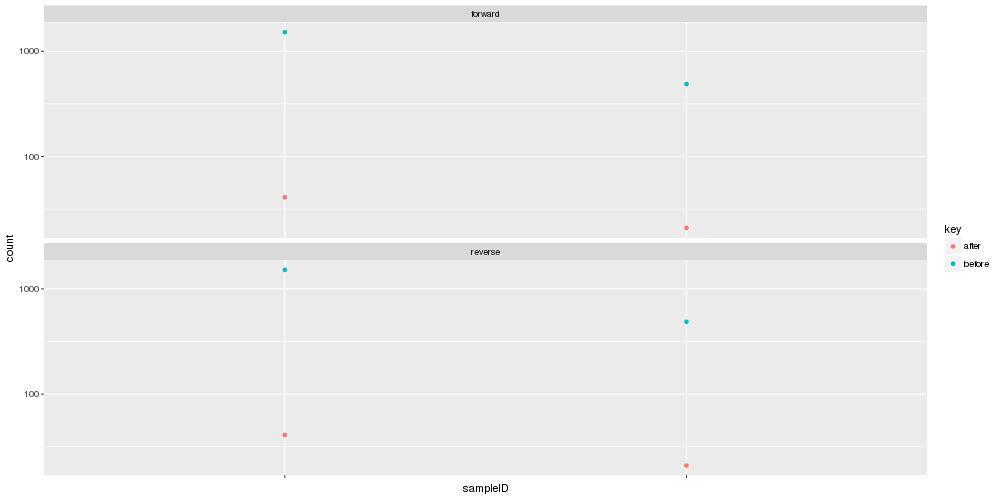

In [17]:
%%R -w 1000 -h 500
get_counts = function(dd) {
    data.frame(after = length(dd$denoised), before = sum(dd$denoised))
}

#names(dadaFs) = sample_names
#names(dadaRs) = sample_names

fwd = plyr::ldply(dadaFsblank, get_counts, .id = "sampleID") %>% tbl_df %>% mutate(read = "forward")
rev = plyr::ldply(dadaFsblank, get_counts, .id = "sampleID") %>% tbl_df %>% mutate(read = "reverse")

d = rbind(fwd, rev) %>%
    tidyr::gather(key, count, -sampleID, -read) %>% {
        ord = filter(., key == "after", read == "forward") %>%
            arrange(desc(count)) %>%
            magrittr::extract2("sampleID")
        .$sampleID = factor(.$sampleID, levels = ord)
        .
    }


p = ggplot(d, aes(x = sampleID, y = count, color = key))

p = p + facet_wrap(~read, ncol = 1)

p = p + geom_point()

p = p + scale_y_log10()

p = p + theme(axis.text.x = element_blank())

p

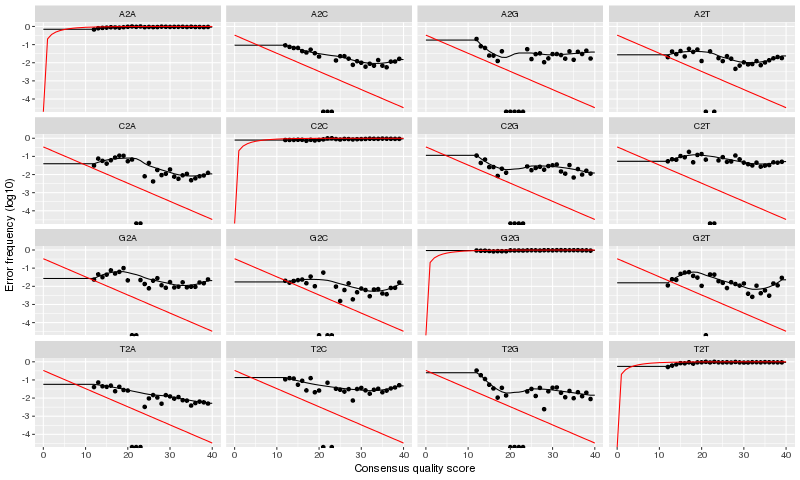

In [18]:
%%R -w 800
plotErrors(dadaFsblank[[1]], nominalQ=TRUE)

## Merge reverse and foward reads

In [42]:
%%R
mergers = mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=FALSE)


Error in is(dadaF, "dada") : object 'dadaFs' not found


/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in is(dadaF, "dada") : object 'dadaFs' not found

  warnings.warn(x, RRuntimeWarning)


In [19]:
%%R
mergersblank = mergePairs(dadaFsblank, derepFsblank, dadaRsblank, derepRsblank, verbose=FALSE)

In [41]:
%%R
seqtab = makeSequenceTable(mergers)
dim(seqtab)


Error in match(x, table, nomatch = 0L) : object 'mergers' not found


/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in match(x, table, nomatch = 0L) : object 'mergers' not found

  warnings.warn(x, RRuntimeWarning)
/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In FUN(X[[i]], ...) :
  warnings.warn(x, RRuntimeWarning)
/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  verbose

In [20]:
%%R
seqtabblank = makeSequenceTable(mergersblank)
dim(seqtabblank)

/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The sequences being tabled vary in length.

  warnings.warn(x, RRuntimeWarning)


[1]  2 43


In [7]:
%%R -h 350
nchar(colnames(seqtab)) %>% 
    hist(breaks = 10, main = "Sequence length histogram")


Error in colnames(seqtab) : object 'seqtab' not found


/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in colnames(seqtab) : object 'seqtab' not found

  warnings.warn(x, RRuntimeWarning)


### Removing Chimeras 

In [18]:
%%R
seqtab.nochim = removeBimeraDenovo(seqtab, verbose=TRUE)
dim(seqtab.nochim)


Error in removeBimeraDenovo(seqtab, verbose = TRUE) : 
  object 'seqtab' not found


/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in removeBimeraDenovo(seqtab, verbose = TRUE) : 
  object 'seqtab' not found

  warnings.warn(x, RRuntimeWarning)


In [21]:
%%R
seqtab.nochim.blank = removeBimeraDenovo(seqtabblank, verbose=TRUE)
dim(seqtab.nochim.blank)

/home/elliot/anaconda3/envs/seastar/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Identified 0 bimeras out of 43 input sequences.

  warnings.warn(x, RRuntimeWarning)


[1]  2 43


In [ ]:
%%R
dim(seqtab.nochim.blank)

In [ ]:
%%R
uniquesToFasta(getUniques(seqtab.nochim), 
               "data/EC_fasta.fa", 
               ids=paste0("Sequence", ".", seq(length(getUniques(seqtab.nochim)))))

In [22]:
%%R
uniquesToFasta(getUniques(seqtab.nochim.blank), 
               "data/EC_blank_fasta.fa", 
               ids=paste0("Sequence", ".", seq(length(getUniques(seqtab.nochim.blank)))))

In [23]:
%%R
seq_blank_tbl = seqtab.nochim.blank %>%
    t %>%
    data.frame %>%
    mutate(seq_id = paste0("Sequence", ".", seq(length(getUniques(seqtab.nochim.blank))))) 

seq_blank_tbl %>%
    write.csv("data/EC_blank_table.csv", row.names = FALSE)

In [37]:
%%R
seq_blank_tbl = readr::read_csv("data/EC_blank_table.csv")

In [39]:
%%R
seq_tbl = readr::read_csv("data/EC_table.csv")

|================================================================================| 100%    3 MB


In [43]:
!head -n2 data/EC_blank_fasta.fa

>Sequence.1
GCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTCTGTTGCGTCCGCTGTGAAAACTCGGGGCTTAACCCCGAGCCTGCAGTGGATACGGGCAGACTAGAGGTAGGTAGGGGAGAATGGAATTCCCGGTGTAGCGGTGAAATGCGCAGATATCGGGAGGAACACCGGTGGCGAAGGCGGTTCTCTGGGCCTTACCTGACGCTGAGGAGCGAAAGCGTGGGG


In [33]:
!head data/EC_table.csv | cut -c 1-80

"X8106_PC","X8110_BP","X8116_BP","X8137_BP","X8143_BP","X8161_W","X8163_W","X817
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
41,593,1793,339,706,0,17,1015,1664,272,86,132,632,307,966,668,1471,12,62,42,164,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,
59,0,21,43,0,0,0,19,17,0,0,0,0,0,0,23,0,18,103,575,0,0,0,0,0,10,0,0,334,45,0,18,
1340,1380,908,602,94,0,0,2417,699,0,0,187,1434,803,249,3073,3483,335,1151,1020,7
1536,1221,602,770,173,0,0,1819,440,0,0,204,1059,710,345,2028,3243,424,1240,858,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,14,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
1403,692,322,252,90,0,0,982,282,0,0,110,720,513,234,1038,1858,491,1095,978,243,1


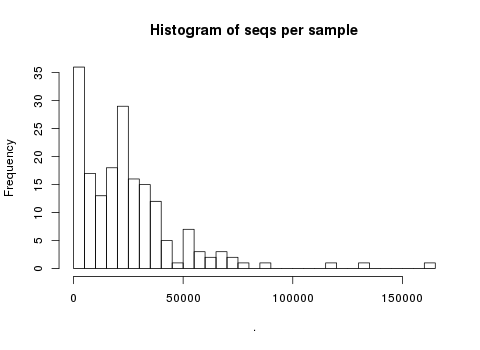

In [40]:
%%R -h 350
seq_tbl %>%
    tidyr::gather(sample, count, -seq_id) %>%
    group_by(sample) %>%
    summarize(count = sum(count)) %>%
    ungroup() %>%
    arrange(desc(count)) %>%
    magrittr::extract2("count") %>%
    hist(breaks = 50, main = "Histogram of seqs per sample")

In [46]:
to_remove = !egrep "Mitochondria|Chloroplast" data/tax_table.csv | awk -F"," '{print $1}'

In [47]:
df = pd.read_csv("data/EC_table.csv")
df[-df["seq_id"].isin(to_remove)].to_csv("data/EC_table.noMC.csv", index=False)

In [48]:
!wc -l data/EC_table* data/to_remove.txt

   9651 data/EC_table.csv
   9468 data/EC_table.noMC.csv
    136 data/to_remove.txt
  19255 total


In [49]:
keepers = []
with open("data/EC_fasta.noMC.fa", "w") as out:
    for rec in SeqIO.parse("data/EC_fasta.fa", "fasta"):
        if rec.name in to_remove:
            continue
        keepers.append(rec)
    writer = SeqIO.FastaIO.FastaWriter(out, wrap=0)
    writer.write_file(keepers)
!grep -c ">" data/EC_fasta.*fa

data/EC_fasta.fa:9650
data/EC_fasta.noMC.fa:9467


## Fixing naming of libraries

In [50]:
!sed -i 's/X8508_CF/X8507_CF/g' data/EC_table.*csv
!sed -i 's/C565,/C565_TF,/g' data/EC_table.*csv
!sed -i 's/C205,/C209_5_TF,/g' data/EC_table.*csv